In [35]:
import urllib.request

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = "/content/imagenet_class_index.json"

urllib.request.urlretrieve(url, save_path)
print("Downloaded ImageNet class index.")


Downloaded ImageNet class index.


In [36]:
import torch, torchvision, json, os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mean & std from instructions
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Load dataset
dataset_path = "/content/TestDataSet/TestDataSet"
dataset = ImageFolder(root=dataset_path, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load model
resnet = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
resnet.eval()

# Load class map
with open("/content/imagenet_class_index.json") as f:
    idx_to_label = json.load(f)
wnid_to_idx = {v[0]: int(k) for k, v in idx_to_label.items()}
folder_to_idx = dataset.class_to_idx
folderidx_to_imagenetidx = {folder_to_idx[wnid]: wnid_to_idx[wnid] for wnid in folder_to_idx}

# Accuracy evaluation
def evaluate_model(model, data_loader, label_map):
    top1_total = top5_total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.topk(5, dim=1).indices.cpu()
            gt = torch.tensor([label_map[l.item()] for l in labels]).view(-1, 1)
            top1_total += (preds[:, 0:1] == gt).sum().item()
            top5_total += (preds == gt).sum().item()
    total = len(data_loader.dataset)
    return top1_total / total, top5_total / total

# Run evaluation
top1, top5 = evaluate_model(resnet, loader, folderidx_to_imagenetidx)
print(f"Task 1 - Clean ResNet-34:")
print(f"Top-1 Accuracy: {top1:.4f}")
print(f"Top-5 Accuracy: {top5:.4f}")


Task 1 - Clean ResNet-34:
Top-1 Accuracy: 0.7600
Top-5 Accuracy: 0.9420


In [37]:
def fgsm_attack_raw_targeted(model, image, true_label, target_label, epsilon=0.02):
    mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std_norms).view(1, 3, 1, 1).to(image.device)

    image_raw = (image * std + mean).clone().detach().requires_grad_(True)
    output = model((image_raw - mean) / std)

    # Targeted loss
    loss = torch.nn.CrossEntropyLoss()(output, target_label)
    model.zero_grad()
    loss.backward()

    # Targeted FGSM: subtract gradient to move toward target class
    perturbed_raw = image_raw - epsilon * image_raw.grad.sign()
    perturbed_raw = torch.clamp(perturbed_raw, 0, 1)

    return (perturbed_raw - mean) / std  # Return normalized image


In [38]:
adv_images_1 = []
true_labels_1 = []

resnet.eval()
for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    for img, lbl in zip(images, labels):
        img = img.unsqueeze(0)
        lbl = lbl.unsqueeze(0)

        # Use a fixed wrong target class
        target = ((lbl + 5) % 1000).to(device)

        adv = fgsm_attack_raw_targeted(resnet, img, lbl, target, epsilon=0.02)
        adv_images_1.append(adv.cpu())
        true_labels_1.append(lbl.cpu())

# Save to disk
torch.save((adv_images_1, true_labels_1), "/content/adv_testset1.pt")
print("Task 2: Targeted FGSM dataset created and saved as adv_testset1.pt")


Task 2: Targeted FGSM dataset created and saved as adv_testset1.pt


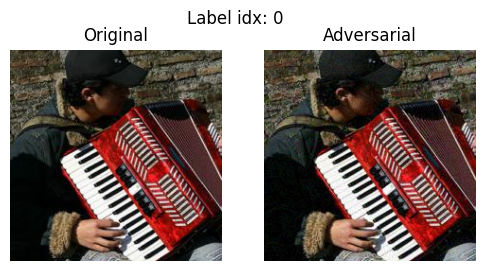

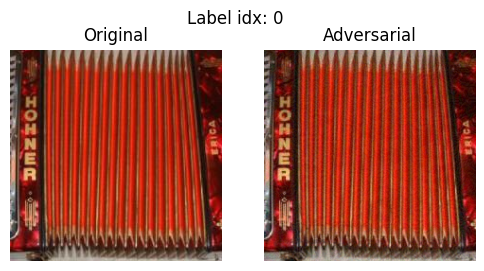

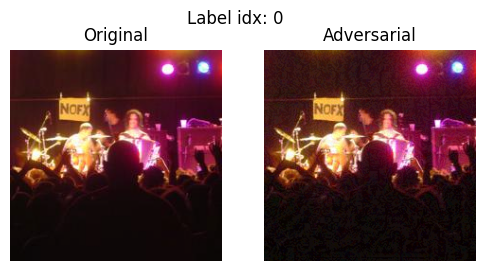

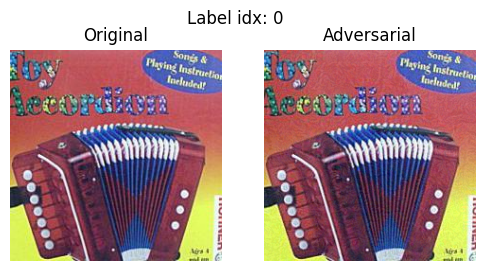

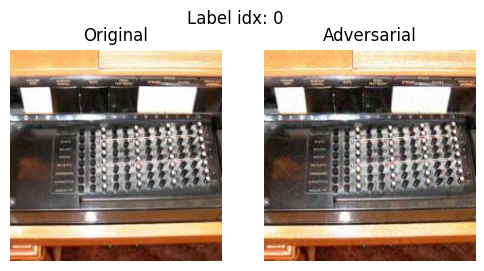

In [39]:
def show_images(orig, adv, label_idx):
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean_norms, std_norms)],
        std=[1/s for s in std_norms]
    )
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(inv_normalize(orig.squeeze().detach()).permute(1, 2, 0).numpy())
    axs[0].set_title("Original")
    axs[1].imshow(inv_normalize(adv.squeeze().detach()).permute(1, 2, 0).numpy())
    axs[1].set_title("Adversarial")
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f"Label idx: {label_idx}")
    plt.show()

# Show 5 pairs
for i in range(5):
    show_images(dataset[i][0].unsqueeze(0), adv_images_1[i], dataset[i][1])


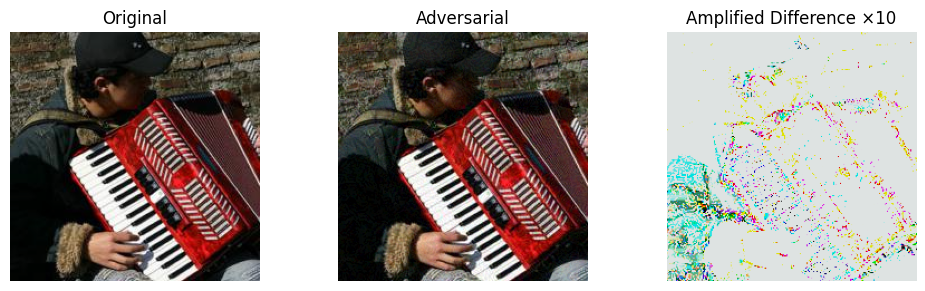

In [40]:
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Sample: compare original vs FGSM image
orig_img = dataset[0][0]                 # normalized tensor
adv_img = adv_images_1[0].squeeze(0)     # from your FGSM list

# Amplified difference
diff = (adv_img - orig_img).abs() * 10
diff = diff.clamp(0, 1)

# Unnormalize for display
inv_normalize = T.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.imshow(inv_normalize(orig_img.detach()).permute(1, 2, 0).numpy())
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(inv_normalize(adv_img.detach()).permute(1, 2, 0).numpy())
plt.title('Adversarial')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(diff.detach().permute(1, 2, 0).numpy())
plt.title('Amplified Difference ×10')
plt.axis('off')

plt.tight_layout()
plt.show()


In [41]:
adv_images_1_tensor = torch.cat(adv_images_1, dim=0)
true_labels_1_tensor = torch.cat(true_labels_1)

adv_loader1 = DataLoader(
    list(zip(adv_images_1_tensor, true_labels_1_tensor)),
    batch_size=32, shuffle=False
)

top1_total, top5_total = 0, 0
with torch.no_grad():
    for images, labels in adv_loader1:
        images = images.to(device)
        outputs = resnet(images)
        preds = outputs.topk(5, dim=1).indices.cpu()
        gt = torch.tensor([folderidx_to_imagenetidx[l.item()] for l in labels]).view(-1, 1)
        top1_total += (preds[:, 0:1] == gt).sum().item()
        top5_total += (preds == gt).sum().item()

total = len(true_labels_1_tensor)
print(f"\n⚠️ Task 2 FGSM Evaluation (ε = 0.02):")
print(f"Top-1 Accuracy: {top1_total / total:.4f}")
print(f"Top-5 Accuracy: {top5_total / total:.4f}")



⚠️ Task 2 FGSM Evaluation (ε = 0.02):
Top-1 Accuracy: 0.1040
Top-5 Accuracy: 0.2460


In [42]:
def pgd_attack_raw_targeted(model, image, true_label, target_label, epsilon=0.02, alpha=0.002, iters=40):
    mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std_norms).view(1, 3, 1, 1).to(image.device)

    ori = (image * std + mean).clone().detach()
    adv = ori.clone().detach()

    for _ in range(iters):
        adv.requires_grad_(True)
        output = model((adv - mean) / std)
        loss = torch.nn.CrossEntropyLoss()(output, target_label)
        model.zero_grad()
        loss.backward()

        adv = adv - alpha * adv.grad.sign()  # Targeted: move toward target
        eta = torch.clamp(adv - ori, min=-epsilon, max=epsilon)
        adv = torch.clamp(ori + eta, 0, 1).detach()

    return (adv - mean) / std  # return normalized image


In [43]:
adv_images_2 = []
true_labels_2 = []

resnet.eval()
for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    for img, lbl in zip(images, labels):
        img = img.unsqueeze(0)
        lbl = lbl.unsqueeze(0)
        target = ((lbl + 5) % 1000).to(device)

        adv = pgd_attack_raw_targeted(resnet, img, lbl, target, epsilon=0.02, alpha=0.002, iters=40)
        adv_images_2.append(adv.cpu())
        true_labels_2.append(lbl.cpu())

torch.save((adv_images_2, true_labels_2), "/content/adv_testset2.pt")
print("Task 3: PGD dataset created and saved as adv_testset2.pt")


Task 3: PGD dataset created and saved as adv_testset2.pt


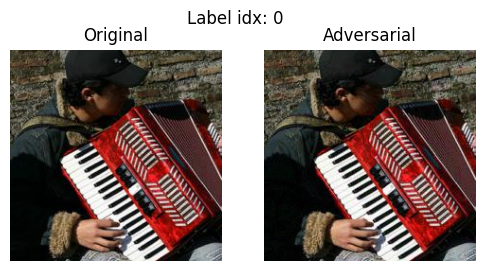

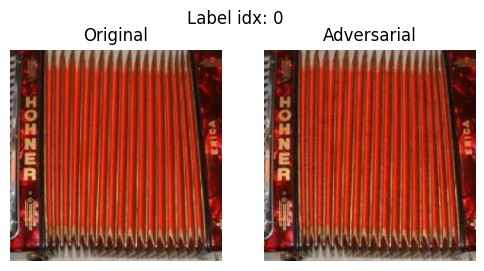

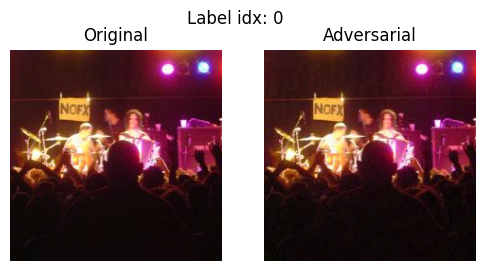

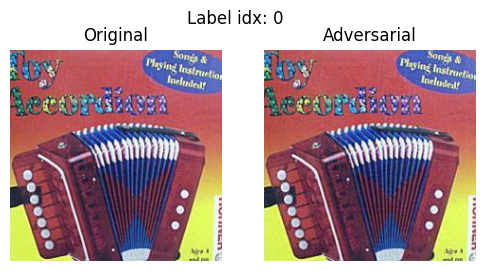

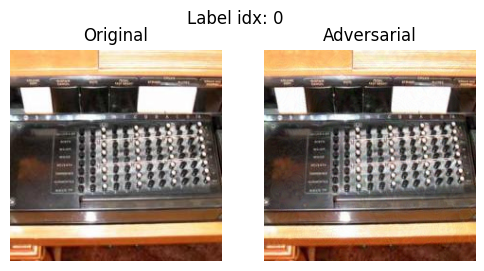

In [44]:
for i in range(5):
    show_images(dataset[i][0].unsqueeze(0), adv_images_2[i], dataset[i][1])


In [45]:
adv_images_2_tensor = torch.cat(adv_images_2, dim=0)
true_labels_2_tensor = torch.cat(true_labels_2)

adv_loader2 = DataLoader(
    list(zip(adv_images_2_tensor, true_labels_2_tensor)),
    batch_size=32, shuffle=False
)

top1_total, top5_total = 0, 0
with torch.no_grad():
    for images, labels in adv_loader2:
        images = images.to(device)
        outputs = resnet(images)
        preds = outputs.topk(5, dim=1).indices.cpu()
        gt = torch.tensor([folderidx_to_imagenetidx[l.item()] for l in labels]).view(-1, 1)

        top1_total += (preds[:, 0:1] == gt).sum().item()
        top5_total += (preds == gt).sum().item()

total = len(true_labels_2_tensor)
print(f"\nTask 3 PGD Evaluation (ε = 0.02):")
print(f"Top-1 Accuracy: {top1_total / total:.4f}")
print(f"Top-5 Accuracy: {top5_total / total:.4f}")



Task 3 PGD Evaluation (ε = 0.02):
Top-1 Accuracy: 0.0000
Top-5 Accuracy: 0.0300


In [46]:
def patch_pgd_attack_targeted(model, image, true_label, target_label,
                               epsilon=0.5, alpha=0.05, iters=40, patch_size=32):
    mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std_norms).view(1, 3, 1, 1).to(image.device)

    ori = (image * std + mean).clone().detach()
    adv = ori.clone().detach()

    _, _, H, W = image.shape
    x = np.random.randint(0, W - patch_size)
    y = np.random.randint(0, H - patch_size)

    for _ in range(iters):
        # Reset the adv image to be detached (avoid graph reuse)
        adv = adv.clone().detach()

        # Extract patch as a fresh leaf tensor
        patch = adv[:, :, y:y+patch_size, x:x+patch_size].clone().detach().requires_grad_(True)

        # Insert patch back into image
        adv_new = adv.clone()
        adv_new[:, :, y:y+patch_size, x:x+patch_size] = patch

        # Forward + loss + backward
        output = model((adv_new - mean) / std)
        loss = torch.nn.CrossEntropyLoss()(output, target_label)
        model.zero_grad()
        loss.backward()

        # Update patch
        patch = patch - alpha * patch.grad.sign()
        patch = torch.clamp(patch, 0, 1)

        # Project perturbation into ε-ball
        eta = torch.clamp(patch - ori[:, :, y:y+patch_size, x:x+patch_size], -epsilon, epsilon)
        adv[:, :, y:y+patch_size, x:x+patch_size] = torch.clamp(
            ori[:, :, y:y+patch_size, x:x+patch_size] + eta, 0, 1
        )

    return (adv - mean) / std


In [47]:
adv_images_3 = []
true_labels_3 = []

resnet.eval()
for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    for img, lbl in zip(images, labels):
        img = img.unsqueeze(0)
        lbl = lbl.unsqueeze(0)
        target = ((lbl + 5) % 1000).to(device)

        adv = patch_pgd_attack_targeted(
            resnet, img, lbl, target,
            epsilon=0.5, alpha=0.05, iters=40, patch_size=32
        )
        adv_images_3.append(adv.cpu())
        true_labels_3.append(lbl.cpu())

torch.save((adv_images_3, true_labels_3), "/content/adv_testset3.pt")
print("Task 4: Patch-based PGD dataset saved as adv_testset3.pt")


Task 4: Patch-based PGD dataset saved as adv_testset3.pt


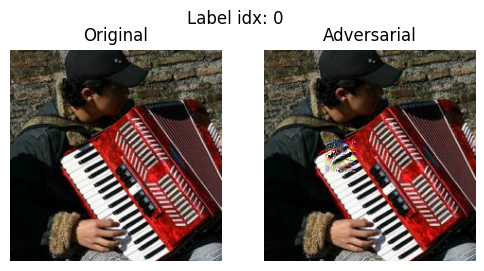

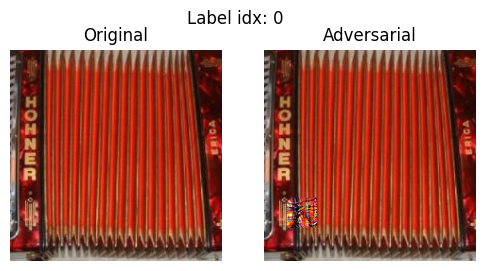

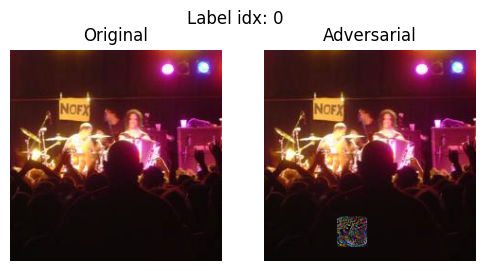

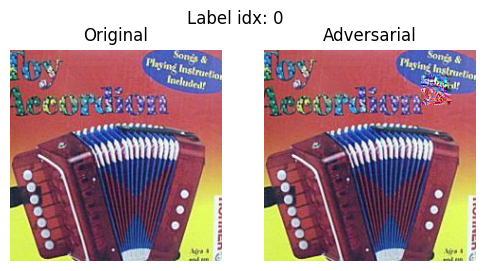

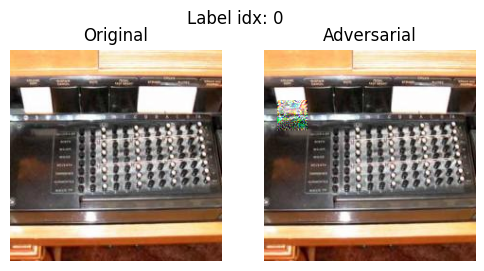

In [48]:
for i in range(5):
    show_images(dataset[i][0].unsqueeze(0), adv_images_3[i], dataset[i][1])


In [49]:
adv_images_3_tensor = torch.cat(adv_images_3, dim=0)
true_labels_3_tensor = torch.cat(true_labels_3)

adv_loader3 = DataLoader(
    list(zip(adv_images_3_tensor, true_labels_3_tensor)),
    batch_size=32, shuffle=False
)

top1_total, top5_total = 0, 0
with torch.no_grad():
    for images, labels in adv_loader3:
        images = images.to(device)
        outputs = resnet(images)
        preds = outputs.topk(5, dim=1).indices.cpu()
        gt = torch.tensor([folderidx_to_imagenetidx[l.item()] for l in labels]).view(-1, 1)

        top1_total += (preds[:, 0:1] == gt).sum().item()
        top5_total += (preds == gt).sum().item()

total = len(true_labels_3_tensor)
print(f"\n Task 4 Patch Attack (ε = 0.5, 32x32):")
print(f"Top-1 Accuracy: {top1_total / total:.4f}")
print(f"Top-5 Accuracy: {top5_total / total:.4f}")



 Task 4 Patch Attack (ε = 0.5, 32x32):
Top-1 Accuracy: 0.4200
Top-5 Accuracy: 0.7220


In [50]:
densenet = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)
densenet.eval()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [51]:
def evaluate_model(model, data_loader, label_map):
    top1_total = top5_total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.topk(5, dim=1).indices.cpu()
            gt = torch.tensor([label_map[l.item()] for l in labels]).view(-1, 1)
            top1_total += (preds[:, 0:1] == gt).sum().item()
            top5_total += (preds == gt).sum().item()
    total = len(data_loader.dataset)
    return top1_total / total, top5_total / total


In [52]:
# Original
loader_orig = loader  # already created in Task 1

# Adversarial loaders
adv_loader1 = DataLoader(
    list(zip(torch.cat(adv_images_1, dim=0), torch.cat(true_labels_1))),
    batch_size=32, shuffle=False
)

adv_loader2 = DataLoader(
    list(zip(torch.cat(adv_images_2, dim=0), torch.cat(true_labels_2))),
    batch_size=32, shuffle=False
)

adv_loader3 = DataLoader(
    list(zip(torch.cat(adv_images_3, dim=0), torch.cat(true_labels_3))),
    batch_size=32, shuffle=False
)


In [53]:
top1_orig, top5_orig = evaluate_model(densenet, loader_orig, folderidx_to_imagenetidx)
top1_fgsm, top5_fgsm = evaluate_model(densenet, adv_loader1, folderidx_to_imagenetidx)
top1_pgd, top5_pgd = evaluate_model(densenet, adv_loader2, folderidx_to_imagenetidx)
top1_patch, top5_patch = evaluate_model(densenet, adv_loader3, folderidx_to_imagenetidx)

print("Task 5: DenseNet-121 Transfer Evaluation")
print(f"Original         - Top-1: {top1_orig:.4f}, Top-5: {top5_orig:.4f}")
print(f"FGSM (AdvSet1)   - Top-1: {top1_fgsm:.4f}, Top-5: {top5_fgsm:.4f}")
print(f"PGD  (AdvSet2)   - Top-1: {top1_pgd:.4f}, Top-5: {top5_pgd:.4f}")
print(f"Patch (AdvSet3)  - Top-1: {top1_patch:.4f}, Top-5: {top5_patch:.4f}")


Task 5: DenseNet-121 Transfer Evaluation
Original         - Top-1: 0.7480, Top-5: 0.9360
FGSM (AdvSet1)   - Top-1: 0.5820, Top-5: 0.8360
PGD  (AdvSet2)   - Top-1: 0.7080, Top-5: 0.8960
Patch (AdvSet3)  - Top-1: 0.7260, Top-5: 0.9140


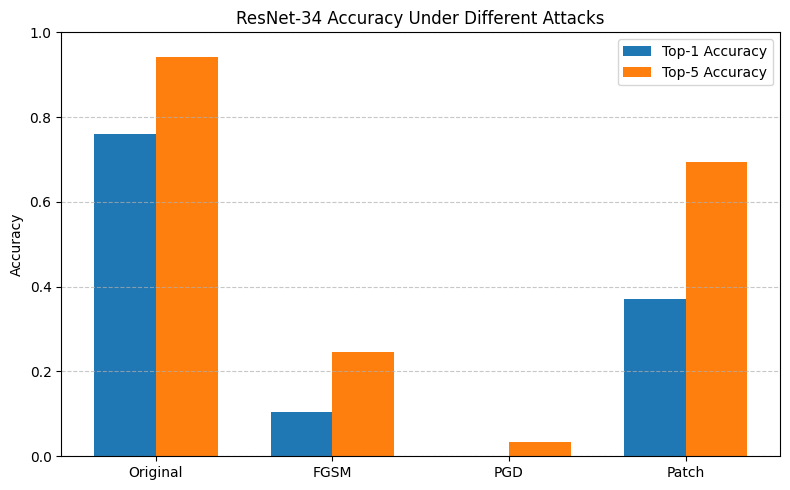

In [54]:
import matplotlib.pyplot as plt

datasets = ['Original', 'FGSM', 'PGD', 'Patch']
top1 = [0.76, 0.104, 0.0, 0.37]
top5 = [0.942, 0.246, 0.034, 0.694]

x = range(len(datasets))

plt.figure(figsize=(8, 5))
plt.bar(x, top1, width=0.35, label='Top-1 Accuracy')
plt.bar([i + 0.35 for i in x], top5, width=0.35, label='Top-5 Accuracy')
plt.xticks([i + 0.175 for i in x], datasets)
plt.ylim(0, 1.0)
plt.title('ResNet-34 Accuracy Under Different Attacks')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("resnet34_attack_accuracy.png")
plt.show()


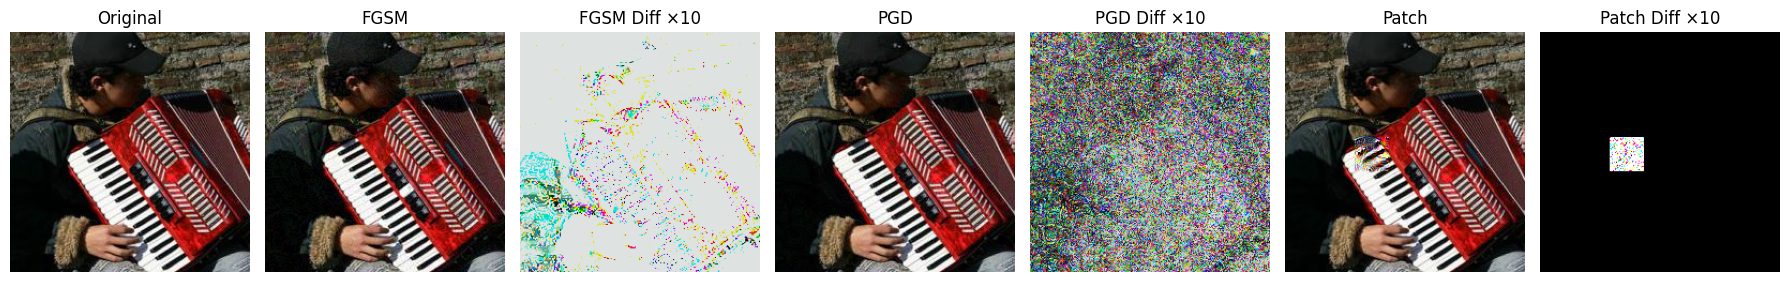

In [55]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Define inverse normalization
inv_normalize = T.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

def show_comparison(index=0):
    orig = dataset[index][0]  # original normalized tensor
    fgsm = adv_images_1[index].squeeze(0)
    pgd = adv_images_2[index].squeeze(0)
    patch = adv_images_3[index].squeeze(0)

    def unnorm(t): return inv_normalize(t.detach()).permute(1, 2, 0).clamp(0, 1).numpy()
    def diff_img(a, b): return (a - b).abs().detach().clamp(0, 1) * 10

    images = [
        unnorm(orig),
        unnorm(fgsm),
        diff_img(fgsm, orig).permute(1, 2, 0).numpy(),
        unnorm(pgd),
        diff_img(pgd, orig).permute(1, 2, 0).numpy(),
        unnorm(patch),
        diff_img(patch, orig).permute(1, 2, 0).numpy()
    ]

    titles = [
        "Original",
        "FGSM",
        "FGSM Diff ×10",
        "PGD",
        "PGD Diff ×10",
        "Patch",
        "Patch Diff ×10"
    ]

    plt.figure(figsize=(18, 4))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_comparison(index=0)


In [56]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os

# Create output directory
os.makedirs("figures", exist_ok=True)

# --- 1. Save Accuracy Bar Plot ---
datasets = ['Original', 'FGSM', 'PGD', 'Patch']
top1 = [0.76, 0.104, 0.0, 0.37]
top5 = [0.942, 0.246, 0.034, 0.694]
x = range(len(datasets))

plt.figure(figsize=(8, 5))
plt.bar(x, top1, width=0.35, label='Top-1 Accuracy')
plt.bar([i + 0.35 for i in x], top5, width=0.35, label='Top-5 Accuracy')
plt.xticks([i + 0.175 for i in x], datasets)
plt.ylim(0, 1.0)
plt.title('ResNet-34 Accuracy Under Different Attacks')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("figures/accuracy_barplot.png")
plt.close()
print("Saved: figures/accuracy_barplot.png")

# --- 2. Save Adversarial Visualizations for One Example Image ---
inv_normalize = T.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

def save_adv_comparison(index=0, filename="adv_examples"):
    orig = dataset[index][0]
    fgsm = adv_images_1[index].squeeze(0)
    pgd = adv_images_2[index].squeeze(0)
    patch = adv_images_3[index].squeeze(0)

    def unnorm(t): return inv_normalize(t.detach()).permute(1, 2, 0).clamp(0, 1).numpy()
    def diff_img(a, b): return (a - b).abs().detach().clamp(0, 1) * 10

    images = [
        unnorm(orig),
        unnorm(fgsm),
        diff_img(fgsm, orig).permute(1, 2, 0).numpy(),
        unnorm(pgd),
        diff_img(pgd, orig).permute(1, 2, 0).numpy(),
        unnorm(patch),
        diff_img(patch, orig).permute(1, 2, 0).numpy()
    ]

    titles = [
        "Original",
        "FGSM",
        "FGSM_Diff",
        "PGD",
        "PGD_Diff",
        "Patch",
        "Patch_Diff"
    ]

    plt.figure(figsize=(18, 4))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    save_path = f"figures/{filename}.png"
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Saved: {save_path}")

save_adv_comparison(index=0, filename="adv_visuals_all_attacks")


Saved: figures/accuracy_barplot.png
Saved: figures/adv_visuals_all_attacks.png
